# 1. Introduction

The document will walk you through the codes that I used to select variables using python. We use different techniques to select variables and then finally each technique votes whether they have selected the variable. Finally, the vote is counted and the variables with higher votes are used in the modeling process.

# 2. Load Dataset

In [13]:
#import packages
import os
import pandas as pd
import numpy as np
df = pd.read_csv('bank/bank.csv',sep=';') #Read excel file
#df = pd.read_excel('/Users/mbagav200/Desktop/Medium/bank.xlsx') #Read excel file

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.5+ KB


In [15]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [16]:
df['target'] = df['y'].apply(lambda x : 1 if x == 'yes' else 0)  # Convert to numeric
df = df.drop('y',axis=1) #drop the y column

In [17]:
df['target'].value_counts()

0    4000
1     521
Name: target, dtype: int64

I am going to use a quick way to encode the class variables (Label Encoder). Since some of the variables in the train dataframe are categories

In [18]:
df.select_dtypes?

In [23]:
df["age"].name

'age'

In [21]:
df_bak=df.copy()
df.select_dtypes(include=['object']).head() # 选择离散类别的列

,job,marital,education,default,housing,loan,contact,month,poutcome
0,unemployed,married,primary,no,no,no,cellular,oct,unknown
1,services,married,secondary,no,yes,yes,cellular,may,failure
2,management,single,tertiary,no,yes,no,cellular,apr,failure
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown


In [22]:
# Data transformation
# Convert categorical values to numeric using label encoder
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the categorical variable
fit = df.select_dtypes(include=['object']).apply(lambda x: d[x.name].fit_transform(x)) # 对所有离散类别的列进行变换

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df[i] = d[i].transform(df[i])

In [28]:
d

defaultdict(sklearn.preprocessing.label.LabelEncoder,
            {'contact': LabelEncoder(),
             'default': LabelEncoder(),
             'education': LabelEncoder(),
             'housing': LabelEncoder(),
             'job': LabelEncoder(),
             'loan': LabelEncoder(),
             'marital': LabelEncoder(),
             'month': LabelEncoder(),
             'poutcome': LabelEncoder()})

In [9]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3,0


In [123]:
features_origin = df_bak.columns.difference(['target'])

In [36]:
features = df[df.columns.difference(['target'])]
labels = df['target']

In [41]:
features.info() # 不应该先将这些feature转为string 类别么?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 16 columns):
age          4521 non-null int64
balance      4521 non-null int64
campaign     4521 non-null int64
contact      4521 non-null int64
day          4521 non-null int64
default      4521 non-null int64
duration     4521 non-null int64
education    4521 non-null int64
housing      4521 non-null int64
job          4521 non-null int64
loan         4521 non-null int64
marital      4521 non-null int64
month        4521 non-null int64
pdays        4521 non-null int64
poutcome     4521 non-null int64
previous     4521 non-null int64
dtypes: int64(16)
memory usage: 565.2 KB


# 3. Variable Selection

## 3.1 Weight of Evidence and Information Value

In [24]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [25]:
final_iv, IV = data_vars(df,df.target)

In [26]:
final_iv.head()

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,age,19,39,2290,259,0.113100,2031,0.886900,0.497121,0.50775,-0.021156,0.000452
1,age,40,87,2231,262,0.117436,1969,0.882564,0.502879,0.49225,0.021363,0.000452
2,job,0,4,2673,287,0.107370,2386,0.892630,0.550864,0.59650,-0.079592,0.008522
3,job,5,11,1848,234,0.126623,1614,0.873377,0.449136,0.40350,0.107150,0.008522
4,marital,0,1,3325,354,0.106466,2971,0.893534,0.679463,0.74275,-0.089057,0.019556


In [27]:
IV.head()

,VAR_NAME,IV
0,age,0.000452
1,balance,0.076208
2,campaign,0.023342
3,contact,0.247734
4,day,0.004581


In [30]:
IV = IV.rename(columns={'VAR_NAME':'index'})

In [34]:
IV.sort_values(['IV'],ascending=0).head()

,index,IV
6,duration,1.651501
3,contact,0.247734
13,pdays,0.203267
15,previous,0.177081
8,housing,0.106556


## 3.2 Variable Importance

In [239]:
features.head()

,age,balance,campaign,contact,day,default,duration,education,housing,job,loan,marital,month,pdays,poutcome,previous
0,30,1787,1,0,19,0,79,0,0,10,0,1,10,-1,3,0
1,33,4789,1,0,11,0,220,1,1,7,1,1,8,339,0,4
2,35,1350,1,0,16,0,185,2,1,4,0,2,0,330,0,1
3,30,1476,4,2,3,0,199,2,1,4,1,1,6,-1,3,0
4,59,0,1,2,5,0,226,1,1,1,0,1,8,-1,3,0


In [240]:
features_str=features.select_dtypes(include=["int64"]).apply(lambda x:x.astype(str))

In [241]:
features_str.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 16 columns):
age          4521 non-null object
balance      4521 non-null object
campaign     4521 non-null object
contact      4521 non-null object
day          4521 non-null object
default      4521 non-null object
duration     4521 non-null object
education    4521 non-null object
housing      4521 non-null object
job          4521 non-null object
loan         4521 non-null object
marital      4521 non-null object
month        4521 non-null object
pdays        4521 non-null object
poutcome     4521 non-null object
previous     4521 non-null object
dtypes: object(16)
memory usage: 565.2+ KB


In [95]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
print("GBDT int64")
clf =XGBClassifier( random_state=0)
clf.fit(features,labels)
preds = clf.predict(features) #两者的结果是一样的

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

GBDT int64
0.9199292191992922


D:\Users\kexin\Anaconda2\envs\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost
#xgboost.plot_tree(clf, num_trees=15)

In [109]:
!pip install pydotplus

  Stored in directory: C:\Users\kexin\AppData\Local\pip\Cache\wheels\35\7b\ab\66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [111]:
import graphviz
import pydotplus

In [104]:
xgboost.to_graphviz?

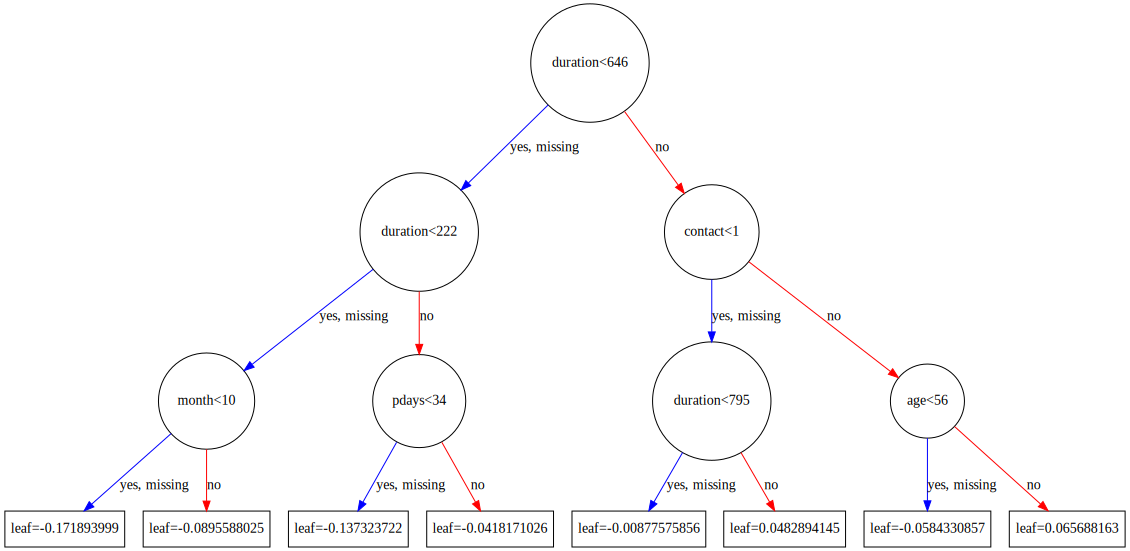

In [106]:
xgboost.to_graphviz(clf, num_trees=1) 
# 可以看出,如month这种类别特征,需要事先将category转为one_hot,否则会出现month<10这种判别特征,其实没有太大意义

In [87]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
print("GBDT str")
clf = XGBClassifier(random_state=0)
clf.fit(features_str,labels) # xgboost并不支持string类型的特征
preds = clf.predict(features_str) #

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

GBDT str


ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields age, balance, campaign, contact, day, default, duration, education, housing, job, loan, marital, month, pdays, poutcome, previous

In [115]:
from sklearn.tree import DecisionTreeClassifier
print("DT str")
clf = DecisionTreeClassifier(random_state=0)
clf.fit(features,labels)
preds = clf.predict(features) #两者的结果是一样的

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)


print("DT str")
clf_str = DecisionTreeClassifier(random_state=0)
clf_str.fit(features_str,labels)
preds = clf_str.predict(features_str) #两者的结果是一样的

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

DT str
1.0
DT str
1.0


In [122]:
from IPython.display import Image
from sklearn import tree
import pydotplus
import os  
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=features.columns,
                         class_names=labels.name,
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
# 使用ipython的终端jupyter notebook显示。
Image(graph.create_png())
# 如果没有ipython的jupyter notebook，可以把此图写到pdf文件里，在pdf文件里查看。
graph.write_pdf("dt_features.pdf") 

True

In [121]:
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=features_str.columns,
                         class_names=labels.name,
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
# 使用ipython的终端jupyter notebook显示。
Image(graph.create_png())
# 如果没有ipython的jupyter notebook，可以把此图写到pdf文件里，在pdf文件里查看。
graph.write_pdf("dt_features_str.pdf") 

True

In [125]:
from sklearn.tree import DecisionTreeClassifier
print("DT origin str")
clf = DecisionTreeClassifier(random_state=0)
clf.fit(features_origin,labels) #可以看出str类型,模型并不能处理,直接报错
preds = clf.predict(features_origin) #两者的结果是一样的

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=features_origin.columns,
                         class_names=labels.name,
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
# 使用ipython的终端jupyter notebook显示。
Image(graph.create_png())
# 如果没有ipython的jupyter notebook，可以把此图写到pdf文件里，在pdf文件里查看。
graph.write_pdf("dt_features_origin.pdf") 

DT origin str


ValueError: could not convert string to float: 'age'

In [86]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
print("GBDT str")
clf = GradientBoostingClassifier(random_state=0)
clf.fit(features,labels)
preds = clf.predict(features) #两者的结果是一样的

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)


from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
print("GBDT str")
clf = GradientBoostingClassifier(random_state=0)
clf.fit(features_str,labels)
preds = clf.predict(features_str) #两者的结果是一样的

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

GBDT str
0.9296615792966157
GBDT str
0.9296615792966157


In [242]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(features,labels)
preds = clf.predict(features) #两者的结果是一样的

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

0.9907100199071002


In [243]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(features_str,labels)
preds = clf.predict(features_str)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

0.9907100199071002


In [244]:
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

In [245]:
VI = VI.reset_index()

In [246]:
VI.sort_values(['RF'],ascending=0)

,index,RF
6,duration,0.29
1,balance,0.12
0,age,0.10
4,day,0.10
12,month,0.07
9,job,0.05
14,poutcome,0.05
13,pdays,0.04
2,campaign,0.04
7,education,0.03


## 3.3 Recursive Feature Elimination

In [136]:
from sklearn.feature_selection import RFE
RFE?

In [128]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, n_features_to_select=20) # 通过 coef_或者feature_importance_逐步消除一些不重要的特征,直到特征数为n_features_to_select
fit = rfe.fit(features, labels)

In [137]:
rfe.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [138]:
features.columns

Index(['age', 'balance', 'campaign', 'contact', 'day', 'default', 'duration',
       'education', 'housing', 'job', 'loan', 'marital', 'month', 'pdays',
       'poutcome', 'previous'],
      dtype='object')

In [134]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns) 
Selected = Selected.reset_index()

In [135]:
Selected

,index,RFE
0,age,True
1,balance,True
2,campaign,True
3,contact,True
4,day,True
5,default,True
6,duration,True
7,education,True
8,housing,True
9,job,True


In [133]:
Selected[Selected['RFE']]

,index,RFE
0,age,True
1,balance,True
2,campaign,True
3,contact,True
4,day,True
5,default,True
6,duration,True
7,education,True
8,housing,True
9,job,True


## 3.4 Variable Importance - Extratrees Classifier

In [141]:
ExtraTreesClassifier?

In [179]:
# randomforest的一个变种
"""
Extra trees是RF的一个变种, 原理几乎和RF一模一样，仅有区别有：
1） 对于每个决策树的训练集，RF采用的是随机采样bootstrap来选择采样集作为每个决策树的训练集，而extra trees一般不采用随机采样，即每个决策树采用原始训练集。
2） 在选定了划分特征后，RF的决策树会基于基尼系数，均方差之类的原则，选择一个最优的特征值划分点，这和传统的决策树相同。但是extra trees比较激进，他会随机选择一个特征值来划分决策树。
"""
from sklearn.ensemble import ExtraTreesClassifier 

model = ExtraTreesClassifier()
model.fit(features, labels)

print(model.feature_importances_)

[0.09202405 0.08685502 0.05891328 0.02791653 0.09055854 0.00553933
 0.25088591 0.04467571 0.01632455 0.06275307 0.0124622  0.03429543
 0.0904971  0.04226763 0.04787374 0.03615789]


In [180]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)

In [181]:
FI = FI.reset_index()

In [182]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
6,duration,0.25
0,age,0.09
4,day,0.09
12,month,0.09
1,balance,0.09
9,job,0.06
2,campaign,0.06
14,poutcome,0.05
7,education,0.04
13,pdays,0.04


## 3.5 Chi Square

In [209]:
df1 = df.copy()
# Chi Square, 度量因变量与y的相关性
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the categorical variable
fit = df1.apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df1[i] = d[i].transform(df1[i])

In [210]:
df1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,11,10,1,0,0,1475,0,0,0,18,10,75,0,0,0,3,0
1,14,7,1,1,0,2030,1,1,0,10,8,216,0,228,4,0,0
2,16,4,2,2,0,1303,1,0,0,15,0,181,0,219,1,0,0
3,11,4,1,2,0,1352,1,1,2,2,6,195,3,0,0,3,0
4,40,1,1,1,0,274,1,0,2,4,8,222,0,0,0,3,0


In [211]:
features1 = df1[df1.columns.difference(['target'])]
labels1 = df1['target']

In [214]:
#SelectKBest?

In [215]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model = SelectKBest(score_func=chi2, k=5) # 计算\chi^2相关性
fit = model.fit(features1, labels1)

In [216]:
import numpy
numpy.set_printoptions(suppress=True)
print(fit.scores_)

[    45.84063034  11343.97706276     88.07290162    100.51007877
      2.60631502      0.00754274 119483.9344331       3.80267508
     21.50080127      8.15459672     19.04525811      0.32039715
     12.32541175   5374.89961779     11.86870754    330.26034213]


In [217]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features1.columns)

In [218]:
chi_sq = chi_sq.reset_index()

In [219]:
chi_sq.sort_values('Chi_Square',ascending=0) #打印所有列与y的相关性

,index,Chi_Square
6,duration,119483.93
1,balance,11343.98
13,pdays,5374.90
15,previous,330.26
3,contact,100.51
2,campaign,88.07
0,age,45.84
8,housing,21.50
10,loan,19.05
12,month,12.33


## 3.6 L1 feature selection

In [220]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [221]:
#LinearSVC?

In [224]:
#SelectFromModel?

In [225]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True) # 用l1做特征选择, abs< 1e-5的特征均不会保留

In [226]:
model.get_support()

array([ True, False,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True])

In [227]:
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)

In [228]:
l1

,L1
age,True
balance,False
campaign,True
contact,True
day,True
default,False
duration,True
education,False
housing,True
job,True


In [229]:
l1 = l1.reset_index() # 只获取那些l1保留的特征

In [230]:
l1[l1['L1'] == True]

,index,L1
0,age,True
2,campaign,True
3,contact,True
4,day,True
6,duration,True
8,housing,True
9,job,True
10,loan,True
11,marital,True
12,month,True


## 3.7 Combine all together

In [231]:
IV.head()

,index,IV
0,age,0.00
1,balance,0.08
2,campaign,0.02
3,contact,0.25
4,day,0.00


In [247]:
VI.head()

,index,RF
0,age,0.10
1,balance,0.12
2,campaign,0.04
3,contact,0.02
4,day,0.10


In [233]:
Selected.head()

,index,RFE
0,age,True
1,balance,True
2,campaign,True
3,contact,True
4,day,True


In [234]:
chi_sq.head()

,index,Chi_Square
0,age,45.84
1,balance,11343.98
2,campaign,88.07
3,contact,100.51
4,day,2.61


In [235]:
l1.head()

,index,L1
0,age,True
1,balance,False
2,campaign,True
3,contact,True
4,day,True


In [248]:
from functools import reduce
#dfs = [IV ,Selected]
dfs = [IV, VI, Selected, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs) # reduce on dfs, 妙!!

In [249]:
final_results.head()

,index,IV,RF,RFE,Extratrees,Chi_Square,L1
0,age,0.00,0.10,True,0.09,45.84,True
1,balance,0.08,0.12,True,0.09,11343.98,False
2,campaign,0.02,0.04,True,0.06,88.07,True
3,contact,0.25,0.02,True,0.03,100.51,True
4,day,0.00,0.10,True,0.09,2.61,True


In [250]:
final_results.columns

Index(['index', 'IV', 'RF', 'RFE', 'Extratrees', 'Chi_Square', 'L1'], dtype='object')

## 3.8 Variable Score

In [255]:
final_results.nlargest(5,"IV") #将df按IV列排序选择top5

,index,IV,RF,RFE,Extratrees,Chi_Square,L1
6,duration,1.65,0.29,True,0.25,119483.93,True
3,contact,0.25,0.02,True,0.03,100.51,True
13,pdays,0.20,0.04,True,0.04,5374.90,True
15,previous,0.18,0.03,True,0.04,330.26,True
8,housing,0.11,0.02,True,0.02,21.50,True


In [251]:
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int) # 看当前的列是否在某个metric的重要性前5之内
    
score_table['RFE'] = final_results['RFE'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [256]:
score_table['final_score'] = score_table.sum(axis=1)

In [257]:
score_table.sort_values('final_score',ascending=0) #  按重要性得分可知, duration最重要

,index,IV,RF,Extratrees,Chi_Square,RFE,L1,final_score
6,duration,1,1,1,1,1,1,6
0,age,0,1,1,0,1,1,4
1,balance,0,1,1,1,1,0,4
3,contact,1,0,0,1,1,1,4
4,day,0,1,1,0,1,1,4
12,month,0,1,1,0,1,1,4
13,pdays,1,0,0,1,1,1,4
15,previous,1,0,0,1,1,1,4
8,housing,1,0,0,0,1,1,3
2,campaign,0,0,0,0,1,1,2


## 3.9 Multicollinearity - VIF  (Addon), 多重共线性 

In [ ]:
#!pip install statsmodels

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [260]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [43]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)

/Users/mbagav200/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
vif

,Features,VIF
0,age,7.75
1,balance,1.26
2,campaign,1.87
3,contact,1.99
4,day,4.55
5,default,1.03
6,duration,2.00
7,education,3.64
8,housing,2.52
9,job,2.88
